# KNN Algorithm Explanation in Depth

## 1) Dataset

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split


data = pd.read_csv("cybersecurity_attacks.csv")
data_proc = data

data_proc = data_proc.drop(columns=["Payload Data","Timestamp","Source IP Address","Destination IP Address","Source Port","Destination Port","Device Information","Proxy Information","User Information","Geo-location Data"])
data_proc["Malware Indicators"].fillna("Not Detected", inplace=True)
data_proc["Alerts/Warnings"].fillna("Not Detected", inplace=True)
data_proc["Firewall Logs"].fillna("Not Detected", inplace=True)
data_proc["IDS/IPS Alerts"].fillna("Not Detected", inplace=True)

data_proc

,Protocol,Packet Length,Packet Type,Traffic Type,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,Network Segment,Firewall Logs,IDS/IPS Alerts,Log Source
0,ICMP,503,Data,HTTP,IoC Detected,28.67,Not Detected,Malware,Known Pattern B,Logged,Low,Segment A,Log Data,Not Detected,Server
1,ICMP,1174,Data,HTTP,IoC Detected,51.50,Not Detected,Malware,Known Pattern A,Blocked,Low,Segment B,Log Data,Not Detected,Firewall
2,UDP,306,Control,HTTP,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,Log Data,Alert Data,Firewall
3,UDP,385,Data,HTTP,Not Detected,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Segment B,Not Detected,Alert Data,Firewall
4,TCP,1462,Data,DNS,Not Detected,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Segment C,Not Detected,Alert Data,Firewall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,UDP,1428,Control,HTTP,IoC Detected,39.28,Not Detected,DDoS,Known Pattern A,Logged,Medium,Segment A,Log Data,Alert Data,Firewall
39996,UDP,1184,Control,HTTP,IoC Detected,27.25,Not Detected,DDoS,Known Pattern A,Logged,High,Segment C,Log Data,Not Detected,Firewall
39997,UDP,1043,Data,DNS,IoC Detected,31.01,Not Detected,DDoS,Known Pattern B,Blocked,Low,Segment C,Log Data,Alert Data,Server
39998,UDP,483,Data,FTP,IoC Detected,97.85,Alert Triggered,Malware,Known Pattern B,Ignored,Low,Segment B,Log Data,Not Detected,Server


In [2]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

def process_data_x(train, test):
    # Numerical feature in my Dataset
    numerical_idx = ["Packet Length", "Anomaly Scores"]
    
    # convert numeric integer to float and concat them with already float feature 
     # There are no NaN element in these feature
    X_train = pd.concat([pd.to_numeric(train[numerical_idx[0]],downcast='float'), train[numerical_idx[1]]], axis=1)
    
    oneHot_idx = train.columns.drop(['Packet Length', 'Anomaly Scores','Severity Level'])
    
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ord = OrdinalEncoder(categories=[['Low','Medium','High']])
    
    ord_encoded = ord.fit_transform(train[['Severity Level']])
    oneHot_encoded = oh.fit_transform(train[oneHot_idx])
    
    for i, col in enumerate(oh.get_feature_names_out()):
        X_train[col] = oneHot_encoded[:,i]
   
    for i, col in enumerate(ord.get_feature_names_out()):
        X_train[col] = ord_encoded[:,i]
        
    # --------------
    # process test
    X_test = pd.concat([pd.to_numeric(test[numerical_idx[0]],downcast='float'), test[numerical_idx[1]]], axis=1)
    
    oneHot_idx = test.columns.drop(['Packet Length', 'Anomaly Scores','Severity Level'])
    
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ord = OrdinalEncoder(categories=[['Low','Medium','High']])
    
    ord_encoded = ord.fit_transform(test[['Severity Level']])
    oneHot_encoded = oh.fit_transform(test[oneHot_idx])
    
    for i, col in enumerate(oh.get_feature_names_out()):
        X_test[col] = oneHot_encoded[:,i]
   
    for i, col in enumerate(ord.get_feature_names_out()):
        X_test[col] = ord_encoded[:,i]
    
    
    return X_train, X_test

In [3]:
# label_enc = LabelEncoder()
def process_data_y(train,test):
    
    y_train_enc = label_enc.fit_transform(train)
    y_test_enc = label_enc.transform(test)
    
    return  y_train_enc,y_test_enc

In [4]:
# drop label columns
X = data_proc.drop(columns=["Attack Type"])

# isolate y
y = data_proc["Attack Type"]

# split in Train-set(80%) and Testing-set(20%)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42) 

X_train_enc, X_test_enc = process_data_x(X_train, X_test)

label_enc = LabelEncoder()

y_train_enc = label_enc.fit_transform(y_train)
y_test_enc = label_enc.transform(y_test)

In [5]:
label_enc.classes_

array(['DDoS', 'Intrusion', 'Malware'], dtype=object)

In [6]:
label_enc.inverse_transform([2,1,0])

array(['Malware', 'Intrusion', 'DDoS'], dtype=object)

## 2) KNN | Accuracy 

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

kNN = KNeighborsClassifier(n_neighbors=10)

kNN.fit(X_train_enc,y_train_enc)

y_pred = kNN.predict(X_test_enc)

acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
print (f"Accuracy {acc:.3f}")
y_train_enc

Accuracy 0.332


array([1, 2, 2, ..., 2, 1, 2])

In [8]:
X = X_train_enc.loc[:,'Anomaly Scores' :]
for f in X.columns:
    print ("Feature {:2s} -> Scale: {:7.2f}".format(f, X.loc[:,f].max() - X.loc[:,f].min()) )

Feature Anomaly Scores -> Scale:  100.00
Feature Protocol_ICMP -> Scale:    1.00
Feature Protocol_TCP -> Scale:    1.00
Feature Protocol_UDP -> Scale:    1.00
Feature Packet Type_Control -> Scale:    1.00
Feature Packet Type_Data -> Scale:    1.00
Feature Traffic Type_DNS -> Scale:    1.00
Feature Traffic Type_FTP -> Scale:    1.00
Feature Traffic Type_HTTP -> Scale:    1.00
Feature Malware Indicators_IoC Detected -> Scale:    1.00
Feature Malware Indicators_Not Detected -> Scale:    1.00
Feature Alerts/Warnings_Alert Triggered -> Scale:    1.00
Feature Alerts/Warnings_Not Detected -> Scale:    1.00
Feature Attack Signature_Known Pattern A -> Scale:    1.00
Feature Attack Signature_Known Pattern B -> Scale:    1.00
Feature Action Taken_Blocked -> Scale:    1.00
Feature Action Taken_Ignored -> Scale:    1.00
Feature Action Taken_Logged -> Scale:    1.00
Feature Network Segment_Segment A -> Scale:    1.00
Feature Network Segment_Segment B -> Scale:    1.00
Feature Network Segment_Segment

In [9]:
for k in range(1,11):
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(X_train_enc,y_train_enc)
    y_pred = kNN.predict(X_test_enc)

    # compute Accuracy
    acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
    print (f"k: {k:2d} | Accuracy {acc:.3f}" )

k:  1 | Accuracy 0.335
k:  2 | Accuracy 0.332
k:  3 | Accuracy 0.332
k:  4 | Accuracy 0.334
k:  5 | Accuracy 0.333
k:  6 | Accuracy 0.336
k:  7 | Accuracy 0.332
k:  8 | Accuracy 0.335
k:  9 | Accuracy 0.333
k: 10 | Accuracy 0.332


## 3) KNN | Accuracy with Scaler

### 3.1) MinMax Scaler

The MinMax Scaler is a popular data scaling technique used in various Machine Learning tasks. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

MinMaxScaler doesn’t reduce the effect of outliers, but it linearily scales them down into a fixed range, where the largest occuring data point corresponds to the maximum value and the smallest one corresponds to the minimum value. For an example visualization

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_enc)

array([[0.46309192, 0.0717    , 1.        , ..., 0.        , 1.        ,
        0.5       ],
       [0.96309192, 0.54      , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.73467967, 0.8275    , 0.        , ..., 1.        , 0.        ,
        0.5       ],
       ...,
       [0.21239554, 0.8218    , 1.        , ..., 0.        , 1.        ,
        0.5       ],
       [0.0724234 , 0.1707    , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.32869081, 0.6994    , 0.        , ..., 1.        , 0.        ,
        1.        ]])

In [18]:
X = X_train_enc.loc[:,'Packet Length' :]
for f in X.columns:
    print ("Feature {:2s} -> Scale: {:7.2f}".format(f, X.loc[:,f].max() - X.loc[:,f].min()) )

Feature Packet Length -> Scale: 1436.00
Feature Anomaly Scores -> Scale:  100.00
Feature Protocol_ICMP -> Scale:    1.00
Feature Protocol_TCP -> Scale:    1.00
Feature Protocol_UDP -> Scale:    1.00
Feature Packet Type_Control -> Scale:    1.00
Feature Packet Type_Data -> Scale:    1.00
Feature Traffic Type_DNS -> Scale:    1.00
Feature Traffic Type_FTP -> Scale:    1.00
Feature Traffic Type_HTTP -> Scale:    1.00
Feature Malware Indicators_IoC Detected -> Scale:    1.00
Feature Malware Indicators_Not Detected -> Scale:    1.00
Feature Alerts/Warnings_Alert Triggered -> Scale:    1.00
Feature Alerts/Warnings_Not Detected -> Scale:    1.00
Feature Attack Signature_Known Pattern A -> Scale:    1.00
Feature Attack Signature_Known Pattern B -> Scale:    1.00
Feature Action Taken_Blocked -> Scale:    1.00
Feature Action Taken_Ignored -> Scale:    1.00
Feature Action Taken_Logged -> Scale:    1.00
Feature Network Segment_Segment A -> Scale:    1.00
Feature Network Segment_Segment B -> Scale:

In [19]:
for k in range(1,11):

    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit( scaler.transform(X_train_enc), y_train_enc )
    y_pred = kNN.predict( scaler.transform(X_test_enc) )
    
    # compute Accuracy
    acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
    print ("k: {:2d} | Accuracy {:.3f}".format(k,acc) )


k:  1 | Accuracy 0.339
k:  2 | Accuracy 0.330
k:  3 | Accuracy 0.336
k:  4 | Accuracy 0.339
k:  5 | Accuracy 0.335
k:  6 | Accuracy 0.329
k:  7 | Accuracy 0.336
k:  8 | Accuracy 0.328
k:  9 | Accuracy 0.330
k: 10 | Accuracy 0.333


In [13]:
X_train_enc

,Packet Length,Anomaly Scores,Protocol_ICMP,Protocol_TCP,Protocol_UDP,Packet Type_Control,Packet Type_Data,Traffic Type_DNS,Traffic Type_FTP,Traffic Type_HTTP,...,Network Segment_Segment A,Network Segment_Segment B,Network Segment_Segment C,Firewall Logs_Log Data,Firewall Logs_Not Detected,IDS/IPS Alerts_Alert Data,IDS/IPS Alerts_Not Detected,Log Source_Firewall,Log Source_Server,Severity Level
14307,729.0,7.17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
17812,1447.0,54.00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
11020,1119.0,82.75,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
15158,706.0,86.47,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0
24990,1202.0,63.21,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1214.0,69.40,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0
11284,1246.0,80.79,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0
38158,369.0,82.18,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
860,168.0,17.07,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0


### 3.2) Standard Scaler

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

StandardScaler is sensitive to outliers, and the features may scale differently from each other in the presence of outliers.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_enc)

prova = scaler.fit_transform(X_train_enc) 
prova

array([[-0.12018923, -1.49053755,  1.4010578 , ..., -1.0089778 ,
         1.0089778 , -0.01049714],
       [ 1.60329158,  0.13317741, -0.71374643, ..., -1.0089778 ,
         1.0089778 ,  1.2154459 ],
       [ 0.8159633 ,  1.13001289, -0.71374643, ...,  0.99110208,
        -0.99110208, -0.01049714],
       ...,
       [-0.98433003,  1.11024954,  1.4010578 , ..., -1.0089778 ,
         1.0089778 , -0.01049714],
       [-1.46680864, -1.14727942, -0.71374643, ..., -1.0089778 ,
         1.0089778 ,  1.2154459 ],
       [-0.58346472,  0.68585767, -0.71374643, ...,  0.99110208,
        -0.99110208,  1.2154459 ]])

In [15]:
X = X_train_enc.loc[:,'Packet Length' :]
for f in X.columns:
    print ("Feature {:2s} -> Scale: {:7.2f}".format(f, X.loc[:,f].max() - X.loc[:,f].min()) )

Feature Packet Length -> Scale: 1436.00
Feature Anomaly Scores -> Scale:  100.00
Feature Protocol_ICMP -> Scale:    1.00
Feature Protocol_TCP -> Scale:    1.00
Feature Protocol_UDP -> Scale:    1.00
Feature Packet Type_Control -> Scale:    1.00
Feature Packet Type_Data -> Scale:    1.00
Feature Traffic Type_DNS -> Scale:    1.00
Feature Traffic Type_FTP -> Scale:    1.00
Feature Traffic Type_HTTP -> Scale:    1.00
Feature Malware Indicators_IoC Detected -> Scale:    1.00
Feature Malware Indicators_Not Detected -> Scale:    1.00
Feature Alerts/Warnings_Alert Triggered -> Scale:    1.00
Feature Alerts/Warnings_Not Detected -> Scale:    1.00
Feature Attack Signature_Known Pattern A -> Scale:    1.00
Feature Attack Signature_Known Pattern B -> Scale:    1.00
Feature Action Taken_Blocked -> Scale:    1.00
Feature Action Taken_Ignored -> Scale:    1.00
Feature Action Taken_Logged -> Scale:    1.00
Feature Network Segment_Segment A -> Scale:    1.00
Feature Network Segment_Segment B -> Scale:

In [16]:
for k in range(1,11):

    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit( scaler.transform(X_train_enc), y_train_enc )
    y_pred = kNN.predict( scaler.transform(X_test_enc) )

    # compute Accuracy
    acc = accuracy_score(y_true=y_test_enc, y_pred=y_pred)
    print ("k: {:2d} | Accuracy {:.3f}".format(k,acc) )

k:  1 | Accuracy 0.336
k:  2 | Accuracy 0.334
k:  3 | Accuracy 0.335
k:  4 | Accuracy 0.337
k:  5 | Accuracy 0.330
k:  6 | Accuracy 0.323
k:  7 | Accuracy 0.328
k:  8 | Accuracy 0.328
k:  9 | Accuracy 0.327
k: 10 | Accuracy 0.330


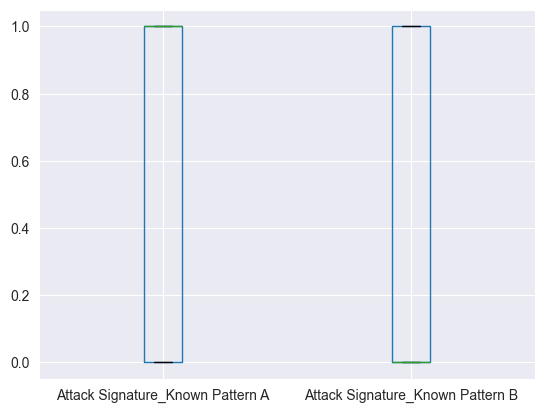

In [17]:
# plot
ax = plt.subplot()
#ax.scatter(y=X_train_enc['Anomaly Scores'],x=X_train_enc['Traffic Type_DNS'],c=y_train_enc, marker='+')
        
boxplot = X_train_enc.boxplot(column=['Attack Signature_Known Pattern A','Attack Signature_Known Pattern B'])

In [18]:
data['Attack Signature'].value_counts()

Attack Signature
Known Pattern A    20076
Known Pattern B    19924
Name: count, dtype: int64

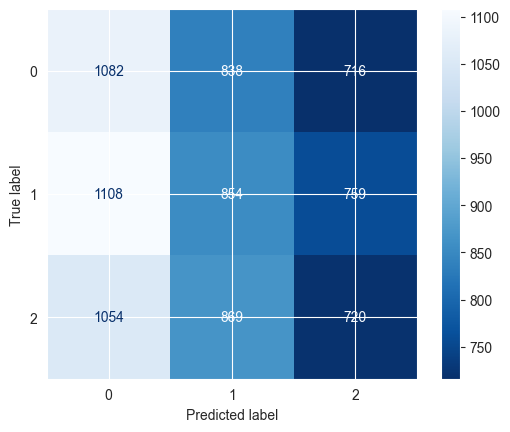

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

kNN = KNeighborsClassifier(n_neighbors=10)
kNN.fit(X_train_enc,y_train_enc)
# y_pred = kNN.predict(X_test_enc)

ConfusionMatrixDisplay.from_estimator(estimator=kNN,
                                      X=X_test_enc, y=y_test_enc,
                                      cmap='Blues_r')

In [21]:
from sklearn.metrics import confusion_matrix

conf_stat = confusion_matrix(y_true=y_test_enc, y_pred=kNN.predict(X_test_enc))

conf_stat

array([[1082,  838,  716],
       [1108,  854,  759],
       [1054,  869,  720]])

In [22]:
data['Attack Type'].value_counts()

Attack Type
DDoS         13428
Malware      13307
Intrusion    13265
Name: count, dtype: int64

## 4) KNN | K-Cross Validation
In this step, a different approach is used. We employ the cross-validation method to assess whether, by using different parts of the dataset as the Validation Set, the accuracy will be higher than before.


In [23]:
# drop label columns
X = data_proc.drop(columns=["Attack Type"])

# isolate y
y = data_proc["Attack Type"]

# split in Train-set(80%) and Testing-set(20%)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42) 

X_train_enc, X_test_enc = process_data_x(X_train, X_test)

label_enc = LabelEncoder()

y_train_enc = label_enc.fit_transform(y_train)
y_test_enc = label_enc.transform(y_test)

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

scores = cross_val_score(kNN,X_train_enc,y_train_enc, cv=5)


In [25]:
scores

array([0.33171875, 0.3396875 , 0.33359375, 0.3359375 , 0.32953125])

In [26]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(kNN,X_train_enc,y_train_enc, cv=cv)

In [27]:
scores

array([0.33166667, 0.33114583, 0.33197917, 0.33427083, 0.3265625 ])

## 5) KNN | Custom Function